In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import cross_comparison
from itertools import accumulate
import torch


rust = False

if rust:
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/pylib"))
    sys.path.insert(0, os.path.abspath("/Users/jarrettye/Codes/anki/out/pylib"))

    from anki._backend import RustBackend

    backend = RustBackend()
    
    from anki.collection import FsrsItem, FsrsReview

In [2]:
from tqdm import tqdm
tqdm.pandas()

def convert_to_items(df):  # -> list[FsrsItem]

    def accumulate(group):
        items = []
        for _, row in group.iterrows():
            t_history = [max(0, int(t)) for t in row["t_history"].split(",")] + [
                row["delta_t"]
            ]
            r_history = [int(t) for t in row["r_history"].split(",")] + [row["rating"]]
            items.append(
                FsrsItem(
                    reviews=[
                        FsrsReview(delta_t=int(x[0]), rating=int(x[1]))
                        for x in zip(t_history, r_history)
                    ]
                )
            )
        return items

    result_list = sum(
        df.sort_values(by=["card_id", "review_th"])
        .groupby("card_id")
        .apply(accumulate)
        .tolist(),
        [],
    )

    return result_list


def cum_concat(x):
    return list(accumulate(x))


def create_time_series(df):
    df = df[(df["delta_t"] != 0) & (df["rating"].isin([1, 2, 3, 4]))].copy()
    df["i"] = df.groupby("card_id").cumcount() + 1
    t_history = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    r_history = df.groupby("card_id", group_keys=False)["rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history for item in sublist
    ]
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history for item in sublist
    ]
    df["tensor"] = [
        torch.tensor((t_item[:-1], r_item[:-1])).transpose(0, 1)
        for t_sublist, r_sublist in zip(t_history, r_history)
        for t_item, r_item in zip(t_sublist, r_sublist)
    ]
    df["y"] = df["rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    return df[df["delta_t"] > 0].sort_values(by=["review_th"]).reset_index(drop=True)

In [3]:
file = Path("../dataset/1000.csv")
dataset = pd.read_csv(file)
dataset = create_time_series(dataset)

  0%|          | 0/27 [00:00<?, ?it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/3230 [00:00<?, ?it/s]

  4%|▎         | 1/27 [00:00<00:04,  5.22it/s]

[0.5614, 1.2546, 3.5878, 7.9731, 5.1043, 1.1303, 0.823, 0.0465, 1.629, 0.135, 1.0045, 2.132, 0.0839, 0.3204, 1.3547, 0.219, 2.7849]
[0.183, 0.9117, 2.2669, 7.9731, 5.0041, 1.0725, 0.6544, 0.2258, 1.7323, 0.1162, 1.1038, 2.0959, 0.1169, 0.2866, 1.305, 0.3575, 2.911]
Pretrain finished!


  4%|▎         | 1/27 [00:00<00:04,  5.22it/s]

dataset built


train:   0%|          | 0/7385 [00:00<?, ?it/s]

[0.183, 0.9117, 2.2669, 7.9731, 5.0041, 1.0725, 0.6544, 0.2258, 1.7323, 0.1162, 1.1038, 2.0959, 0.1169, 0.2866, 1.305, 0.3575, 2.911]
[0.3406, 1.099, 1.6849, 7.9731, 4.8709, 0.921, 0.6022, 0.2647, 1.8485, 0.1015, 1.2201, 2.0887, 0.1179, 0.283, 1.2725, 0.4396, 3.0055]


  7%|▋         | 2/27 [00:00<00:06,  4.10it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/11280 [00:00<?, ?it/s]

 11%|█         | 3/27 [00:00<00:07,  3.18it/s]

[0.3406, 1.099, 1.6849, 7.9731, 4.8709, 0.921, 0.6022, 0.2647, 1.8485, 0.1015, 1.2201, 2.0887, 0.1179, 0.283, 1.2725, 0.4396, 3.0055]
[0.486, 1.2546, 2.6082, 8.7445, 4.8766, 0.9204, 0.6002, 0.2787, 1.886, 0.1, 1.2569, 2.0614, 0.1501, 0.2538, 1.2595, 0.4709, 3.0118]
Pretrain finished!
dataset built


train:   0%|          | 0/15690 [00:00<?, ?it/s]

 15%|█▍        | 4/27 [00:01<00:08,  2.57it/s]

[0.486, 1.2546, 2.6082, 8.7445, 4.8766, 0.9204, 0.6002, 0.2787, 1.886, 0.1, 1.2569, 2.0614, 0.1501, 0.2538, 1.2595, 0.4709, 3.0118]
[0.5404, 1.2459, 2.5461, 7.9731, 4.9616, 1.0414, 0.644, 0.2492, 1.8084, 0.1, 1.1931, 2.0075, 0.1904, 0.2018, 1.1962, 0.4565, 3.1734]
Pretrain finished!
dataset built


train:   0%|          | 0/20310 [00:00<?, ?it/s]

 19%|█▊        | 5/27 [00:02<00:09,  2.24it/s]

[0.5404, 1.2459, 2.5461, 7.9731, 4.9616, 1.0414, 0.644, 0.2492, 1.8084, 0.1, 1.1931, 2.0075, 0.1904, 0.2018, 1.1962, 0.4565, 3.1734]
[0.4714, 1.2319, 2.6903, 7.9731, 4.9889, 1.0751, 0.6586, 0.2329, 1.7976, 0.1, 1.1853, 2.0174, 0.1787, 0.2145, 1.2139, 0.4143, 3.3718]
Pretrain finished!
dataset built


train:   0%|          | 0/23785 [00:00<?, ?it/s]

 22%|██▏       | 6/27 [00:02<00:10,  1.96it/s]

[0.4714, 1.2319, 2.6903, 7.9731, 4.9889, 1.0751, 0.6586, 0.2329, 1.7976, 0.1, 1.1853, 2.0174, 0.1787, 0.2145, 1.2139, 0.4143, 3.3718]
[0.3887, 1.1403, 3.101, 7.9731, 5.009, 1.1505, 0.6022, 0.2832, 1.7533, 0.1, 1.1481, 1.9814, 0.1717, 0.2209, 1.1277, 0.3967, 3.4506]
Pretrain finished!


 22%|██▏       | 6/27 [00:02<00:10,  1.96it/s]

dataset built


train:   0%|          | 0/27340 [00:00<?, ?it/s]

 26%|██▌       | 7/27 [00:03<00:12,  1.66it/s]

[0.3887, 1.1403, 3.101, 7.9731, 5.009, 1.1505, 0.6022, 0.2832, 1.7533, 0.1, 1.1481, 1.9814, 0.1717, 0.2209, 1.1277, 0.3967, 3.4506]
[0.3441, 0.9893, 2.4859, 7.4508, 5.0897, 1.1945, 0.7145, 0.2253, 1.7649, 0.1, 1.1569, 2.0166, 0.165, 0.2587, 1.3118, 0.3984, 3.5479]
Pretrain finished!


 26%|██▌       | 7/27 [00:03<00:12,  1.66it/s]

dataset built


train:   0%|          | 0/30820 [00:00<?, ?it/s]

 30%|██▉       | 8/27 [00:04<00:12,  1.50it/s]

[0.3441, 0.9893, 2.4859, 7.4508, 5.0897, 1.1945, 0.7145, 0.2253, 1.7649, 0.1, 1.1569, 2.0166, 0.165, 0.2587, 1.3118, 0.3984, 3.5479]
[0.3367, 0.9643, 2.3398, 7.9731, 5.0002, 1.0146, 0.6861, 0.2345, 1.6859, 0.1, 1.0797, 2.037, 0.1493, 0.2635, 1.3174, 0.3722, 3.5709]


 30%|██▉       | 8/27 [00:04<00:12,  1.50it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/34745 [00:00<?, ?it/s]

 33%|███▎      | 9/27 [00:05<00:13,  1.37it/s]

[0.3367, 0.9643, 2.3398, 7.9731, 5.0002, 1.0146, 0.6861, 0.2345, 1.6859, 0.1, 1.0797, 2.037, 0.1493, 0.2635, 1.3174, 0.3722, 3.5709]
[0.3153, 0.9867, 1.8327, 6.6553, 5.0963, 1.1659, 0.7174, 0.2141, 1.7394, 0.1, 1.1291, 2.0373, 0.1556, 0.2771, 1.2927, 0.3853, 3.5651]


 33%|███▎      | 9/27 [00:05<00:13,  1.37it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/39470 [00:00<?, ?it/s]

[0.3153, 0.9867, 1.8327, 6.6553, 5.0963, 1.1659, 0.7174, 0.2141, 1.7394, 0.1, 1.1291, 2.0373, 0.1556, 0.2771, 1.2927, 0.3853, 3.5651]
[0.3158, 1.0152, 2.0077, 6.634, 5.024, 1.061, 0.6859, 0.2064, 1.7074, 0.1, 1.0991, 1.9925, 0.161, 0.289, 1.1693, 0.3628, 3.7494]


 37%|███▋      | 10/27 [00:06<00:13,  1.24it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/42715 [00:00<?, ?it/s]

[0.3158, 1.0152, 2.0077, 6.634, 5.024, 1.061, 0.6859, 0.2064, 1.7074, 0.1, 1.0991, 1.9925, 0.161, 0.289, 1.1693, 0.3628, 3.7494]
[0.341, 0.9616, 2.2815, 6.4187, 5.0367, 1.0165, 0.6649, 0.1438, 1.6863, 0.1, 1.0935, 2.0427, 0.1559, 0.2492, 1.512, 0.3046, 3.9236]


 41%|████      | 11/27 [00:07<00:14,  1.10it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/46695 [00:00<?, ?it/s]

[0.341, 0.9616, 2.2815, 6.4187, 5.0367, 1.0165, 0.6649, 0.1438, 1.6863, 0.1, 1.0935, 2.0427, 0.1559, 0.2492, 1.512, 0.3046, 3.9236]
[0.358, 1.1506, 2.2739, 7.9731, 5.0378, 1.016, 0.6083, 0.1834, 1.6089, 0.2015, 1.0356, 1.7564, 0.2, 0.01, 1.1487, 0.2725, 3.9774]


 44%|████▍     | 12/27 [00:08<00:14,  1.03it/s]

Pretrain finished!
dataset built


train:   0%|          | 0/51130 [00:00<?, ?it/s]

[0.358, 1.1506, 2.2739, 7.9731, 5.0378, 1.016, 0.6083, 0.1834, 1.6089, 0.2015, 1.0356, 1.7564, 0.2, 0.01, 1.1487, 0.2725, 3.9774]
[0.3351, 1.1262, 1.8998, 7.9731, 5.0815, 0.9659, 0.6536, 0.1548, 1.5656, 0.2328, 1.002, 1.9503, 0.1642, 0.2144, 1.5045, 0.2828, 4.0]


 48%|████▊     | 13/27 [00:09<00:14,  1.06s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/55430 [00:00<?, ?it/s]

[0.3351, 1.1262, 1.8998, 7.9731, 5.0815, 0.9659, 0.6536, 0.1548, 1.5656, 0.2328, 1.002, 1.9503, 0.1642, 0.2144, 1.5045, 0.2828, 4.0]
[0.3684, 1.1918, 2.0652, 7.9731, 5.134, 1.0332, 0.7148, 0.2985, 1.4441, 0.1797, 0.896, 1.9195, 0.1612, 0.1827, 1.3376, 0.2881, 3.2224]


 52%|█████▏    | 14/27 [00:10<00:14,  1.13s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/59855 [00:00<?, ?it/s]

[0.3684, 1.1918, 2.0652, 7.9731, 5.134, 1.0332, 0.7148, 0.2985, 1.4441, 0.1797, 0.896, 1.9195, 0.1612, 0.1827, 1.3376, 0.2881, 3.2224]
[0.3591, 0.9478, 1.4547, 7.9731, 5.0995, 0.9075, 0.6673, 0.1634, 1.519, 0.2214, 0.9786, 1.8664, 0.1827, 0.1768, 1.3517, 0.2647, 2.4708]


 56%|█████▌    | 15/27 [00:12<00:15,  1.27s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/64835 [00:00<?, ?it/s]

[0.3591, 0.9478, 1.4547, 7.9731, 5.0995, 0.9075, 0.6673, 0.1634, 1.519, 0.2214, 0.9786, 1.8664, 0.1827, 0.1768, 1.3517, 0.2647, 2.4708]
[0.355, 0.9348, 1.4537, 7.9731, 5.1217, 1.0456, 0.6455, 0.2126, 1.4911, 0.1485, 0.9254, 1.9311, 0.1446, 0.2435, 1.5336, 0.236, 2.5966]


 59%|█████▉    | 16/27 [00:14<00:15,  1.37s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/69790 [00:00<?, ?it/s]

[0.355, 0.9348, 1.4537, 7.9731, 5.1217, 1.0456, 0.6455, 0.2126, 1.4911, 0.1485, 0.9254, 1.9311, 0.1446, 0.2435, 1.5336, 0.236, 2.5966]
[0.3509, 0.9337, 1.3217, 7.9731, 5.2178, 1.1248, 0.648, 0.1931, 1.4836, 0.1815, 0.931, 1.9819, 0.169, 0.2296, 1.6836, 0.2578, 2.6362]


 63%|██████▎   | 17/27 [00:15<00:14,  1.46s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/74735 [00:00<?, ?it/s]

[0.3509, 0.9337, 1.3217, 7.9731, 5.2178, 1.1248, 0.648, 0.1931, 1.4836, 0.1815, 0.931, 1.9819, 0.169, 0.2296, 1.6836, 0.2578, 2.6362]
[0.3506, 0.9685, 1.3709, 7.9731, 5.3772, 1.355, 0.5856, 0.2092, 1.5083, 0.2113, 0.9628, 1.9651, 0.1578, 0.2261, 1.5431, 0.2719, 2.5902]


 67%|██████▋   | 18/27 [00:17<00:14,  1.59s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/79735 [00:00<?, ?it/s]

[0.3506, 0.9685, 1.3709, 7.9731, 5.3772, 1.355, 0.5856, 0.2092, 1.5083, 0.2113, 0.9628, 1.9651, 0.1578, 0.2261, 1.5431, 0.2719, 2.5902]
[0.3502, 0.9662, 1.3678, 7.9731, 5.1969, 1.1092, 0.5765, 0.2713, 1.4249, 0.1639, 0.8676, 1.9801, 0.162, 0.2255, 1.4264, 0.2721, 2.7555]


 70%|███████   | 19/27 [00:19<00:13,  1.71s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/84210 [00:00<?, ?it/s]

[0.3502, 0.9662, 1.3678, 7.9731, 5.1969, 1.1092, 0.5765, 0.2713, 1.4249, 0.1639, 0.8676, 1.9801, 0.162, 0.2255, 1.4264, 0.2721, 2.7555]
[0.3296, 0.915, 1.2919, 7.9731, 5.2796, 1.2195, 0.5982, 0.197, 1.4445, 0.1933, 0.8883, 1.9704, 0.1442, 0.2394, 1.4086, 0.28, 2.2935]


 74%|███████▍  | 20/27 [00:21<00:12,  1.81s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/89025 [00:00<?, ?it/s]

[0.3296, 0.915, 1.2919, 7.9731, 5.2796, 1.2195, 0.5982, 0.197, 1.4445, 0.1933, 0.8883, 1.9704, 0.1442, 0.2394, 1.4086, 0.28, 2.2935]
[0.3304, 0.9239, 1.3063, 7.9731, 5.1044, 1.0294, 0.4622, 0.3841, 1.3201, 0.1048, 0.7669, 1.911, 0.1776, 0.2328, 1.4822, 0.2543, 2.2686]


 78%|███████▊  | 21/27 [00:24<00:11,  1.96s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/94025 [00:00<?, ?it/s]

[0.3304, 0.9239, 1.3063, 7.9731, 5.1044, 1.0294, 0.4622, 0.3841, 1.3201, 0.1048, 0.7669, 1.911, 0.1776, 0.2328, 1.4822, 0.2543, 2.2686]
[0.3308, 0.9262, 1.3097, 7.9731, 5.1902, 1.2983, 0.4736, 0.3659, 1.3501, 0.1008, 0.8178, 1.9206, 0.174, 0.2355, 1.5861, 0.2645, 2.388]


 81%|████████▏ | 22/27 [00:26<00:10,  2.10s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/99025 [00:00<?, ?it/s]

[0.3308, 0.9262, 1.3097, 7.9731, 5.1902, 1.2983, 0.4736, 0.3659, 1.3501, 0.1008, 0.8178, 1.9206, 0.174, 0.2355, 1.5861, 0.2645, 2.388]
[0.3313, 0.9286, 1.3131, 7.9731, 5.2035, 1.2154, 0.5946, 0.281, 1.4038, 0.1006, 0.8544, 1.9343, 0.1685, 0.2436, 1.5432, 0.2634, 2.5855]


 85%|████████▌ | 23/27 [00:29<00:08,  2.25s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/104025 [00:00<?, ?it/s]

[0.3313, 0.9286, 1.3131, 7.9731, 5.2035, 1.2154, 0.5946, 0.281, 1.4038, 0.1006, 0.8544, 1.9343, 0.1685, 0.2436, 1.5432, 0.2634, 2.5855]
[0.3318, 0.9314, 1.3171, 7.9731, 5.259, 1.4551, 0.5751, 0.306, 1.4147, 0.1047, 0.8424, 1.935, 0.1546, 0.247, 1.5556, 0.2709, 2.549]


 89%|████████▉ | 24/27 [00:31<00:07,  2.46s/it]

Pretrain finished!


 89%|████████▉ | 24/27 [00:32<00:07,  2.46s/it]

dataset built


train:   0%|          | 0/109025 [00:00<?, ?it/s]

[0.3318, 0.9314, 1.3171, 7.9731, 5.259, 1.4551, 0.5751, 0.306, 1.4147, 0.1047, 0.8424, 1.935, 0.1546, 0.247, 1.5556, 0.2709, 2.549]
[0.3323, 0.9338, 1.3206, 7.9731, 5.2198, 1.2244, 0.5111, 0.2754, 1.4071, 0.1, 0.841, 1.9999, 0.1756, 0.2525, 1.4636, 0.2769, 2.753]


 93%|█████████▎| 25/27 [00:35<00:05,  2.68s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/114025 [00:00<?, ?it/s]

[0.3323, 0.9338, 1.3206, 7.9731, 5.2198, 1.2244, 0.5111, 0.2754, 1.4071, 0.1, 0.841, 1.9999, 0.1756, 0.2525, 1.4636, 0.2769, 2.753]
[0.3326, 0.9356, 1.3231, 7.9731, 5.5356, 1.6022, 0.6237, 0.3203, 1.4646, 0.1001, 0.9001, 1.9255, 0.17, 0.2444, 1.454, 0.3118, 2.2517]


 96%|█████████▋| 26/27 [00:38<00:02,  2.87s/it]

Pretrain finished!
dataset built


train:   0%|          | 0/118950 [00:00<?, ?it/s]

[0.3326, 0.9356, 1.3231, 7.9731, 5.5356, 1.6022, 0.6237, 0.3203, 1.4646, 0.1001, 0.9001, 1.9255, 0.17, 0.2444, 1.454, 0.3118, 2.2517]
[0.3291, 0.9311, 1.2872, 7.9731, 6.0988, 2.0813, 0.9646, 0.0655, 1.7062, 0.1, 1.1578, 1.9286, 0.1824, 0.2517, 1.5035, 0.5063, 2.6095]


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


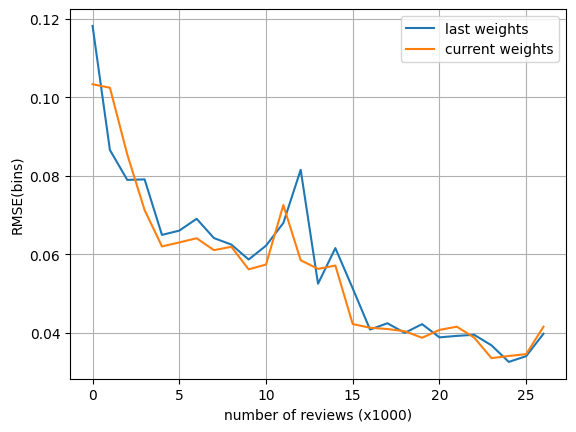

0.5925925925925926


In [7]:
from fsrs_optimizer import (
    Optimizer,
    Collection,
    Trainer,
    power_forgetting_curve,
)
import numpy as np

optimizer = Optimizer()
optimizer.define_model()

def evaluate(weights):
    my_collection = Collection(weights)
    stabilities, difficulties = my_collection.batch_predict(train_set)
    stabilities = map(lambda x: round(x, 2), stabilities)
    difficulties = map(lambda x: round(x, 2), difficulties)
    train_set["stability"] = list(stabilities)
    train_set["difficulty"] = list(difficulties)
    train_set["p"] = power_forgetting_curve(train_set["delta_t"], train_set["stability"])
    y = train_set["y"].tolist()
    p = train_set["p"].tolist()
    rmse_bins = cross_comparison(pd.DataFrame({"y": y, "R (FSRS)": p}), "FSRS", "FSRS")[
        0
    ]
    return rmse_bins


lr: float = 4e-2
n_epoch: int = 5
n_splits: int = 5
batch_size: int = 512
verbose: bool = False

last_weights = optimizer.init_w

m_last = []
m_cur = []
step = 1000
for max_index in tqdm(range(1000, len(dataset), step)):
    train_set = dataset.loc[:max_index].copy()
    if rust:
        items = convert_to_items(train_set[train_set["i"] >= 2])
        weights = backend.compute_weights_from_items(items)
    else:
        optimizer.define_model()
        optimizer.init_w = last_weights.copy()
        optimizer.S0_dataset_group = (
            train_set[train_set["i"] == 2]
            # .groupby(by=["first_rating", "delta_t"], group_keys=False)
            .groupby(by=["r_history", "delta_t"], group_keys=False)
            .agg({"y": ["mean", "count"]})
            .reset_index()
        )
        _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
        trainer = Trainer(
            train_set,
            train_set,
            optimizer.init_w,
            n_epoch=n_epoch,
            lr=lr,
            batch_size=batch_size,
        )
        weights = trainer.train(verbose=verbose)
    print(last_weights)
    print(weights)
    m_last.append(evaluate(last_weights))
    m_cur.append(evaluate(weights))
    last_weights = weights.copy()

plt.plot(m_last, label="last weights")
plt.plot(m_cur, label="current weights")
plt.xlabel(f"number of reviews (x{step})")
plt.ylabel("RMSE(bins)")
plt.legend()
plt.grid()
plt.show()
print(sum((np.array(m_cur) < np.array(m_last))) / len(m_cur))